In [1]:
import argparse
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.animation as animation
import scipy.spatial.distance as dist
from navground import sim, core
from tslearn.generators import random_walks
from tslearn import metrics
import seaborn as sns
import gudhi
from navground.sim.ui.video import display_video_from_run, record_video_from_run
from functools import partial
from IPython.display import Image
import perdiver.perdiver as perdiver
import os
os.makedirs("Corridor_matrices", exist_ok=True)
os.makedirs("plots", exist_ok=True)

In [2]:
poses = np.zeros((600,4, 3))

In [3]:
def pose0x(x):
    x = np.asarray(x)
    return np.where(
        (0 <= x) & (x < 200), x / 10,
        np.where(
            (200 <= x) & (x < 300), 20,
            np.where(
                (300 <= x) & (x < 500), 20 - (x - 300) / 10,
                np.where((500 <= x) & (x <= 600), 0, np.nan)
            )
        )
    )

In [4]:
def pose1x(x):
    x = np.asarray(x)
    return np.where(
        (0 <= x) & (x < 200), (200 - x) / 10,
        np.where(
            (200 <= x) & (x < 300), 0,
            np.where(
                (300 <= x) & (x < 500), x / 10 - 30,
                np.where((500 <= x) & (x <= 600), 20, np.nan)
            )
        )
    )

In [5]:
def pose0alpha(x):
    x = np.asarray(x)
    return np.where(
        (0 <= x) & (x < 200), 0,
        np.where(
            (200 <= x) & (x < 300), np.pi * (x - 200) / 100,
            np.where(
                (300 <= x) & (x < 500), np.pi,
                np.where((500 <= x) & (x <= 600), np.pi + np.pi * (x-500) / 100, np.nan)
            )
        )
    )

In [6]:
def pose1alpha(x):
    x = np.asarray(x)
    return np.where(
        (0 <= x) & (x < 200), np.pi,
        np.where(
            (200 <= x) & (x < 300), np.pi * x / 100 - np.pi,
            np.where(
                (300 <= x) & (x < 500), 2*np.pi,
                np.where((500 <= x) & (x <= 600), 2*np.pi + np.pi* (x - 500) / 100, np.nan)
            )
        )
    )

In [7]:
for t in range(600):
    poses[t][0][0] = pose0x(t) 
    poses[t][1][0] = pose0x(t)
    poses[t][2][0] = pose1x(t) 
    poses[t][3][0] = pose1x(t)
    poses[t][0][1] = 0 
    poses[t][1][1] = 1
    poses[t][2][1] = 2 
    poses[t][3][1] = 3
    poses[t][0][2] = pose0alpha(t) 
    poses[t][1][2] = pose0alpha(t)
    poses[t][2][2] = pose1alpha(t) 
    poses[t][3][2] = pose1alpha(t)

Ahora quiero comparar los sliding windows para ver si se encuentra diferencia entre los incrementos bottleneck y los partial matchings. 

In [8]:
parser = argparse.ArgumentParser(description='Simulation Parameters')
parser.add_argument('--length', type=float, default=10.0, help='Length of the environment')
parser.add_argument('--width', type=float, default=10.0, help='Width of the environment')
parser.add_argument('--num_runs', type=int, default=1, help='Number of simulation runs')
parser.add_argument('--num_steps', type=int, default=100, help='Number of steps in the simulation')
parser.add_argument('--time_step', type=float, default=0.1, help='Time step for the simulation')
parser.add_argument('--num_agents', type=int, default=10, help='Number of agents in the simulation')
parser.add_argument('--max_speed', type=float, default=1.0, help='Maximum speed of agents')
parser.add_argument('--optimal_speed', type=float, default=1.0, help='Maximum speed of agents')
parser.add_argument('--radius', type=float, default=0.25, help='Radius of agents')
parser.add_argument('--safety_margin', type=float, default=0.1, help='Safety margin for agents')
parser.add_argument('--behavior', type=str, default='HL', help='Behavior type')
parser.add_argument('--max_edge_length', type=float, default=100.0, help='Maximum edge length in the simplicial complex')
parser.add_argument('--time_delay', type=int, default=1, help='Time delay to analise simulation intervals')
parser.add_argument('--embedding_length', type=int, default=10, help='Length of the simulation intervals')
parser.add_argument('--epsilon', type=int, default=1, help='Distance between intervals')

_StoreAction(option_strings=['--epsilon'], dest='epsilon', nargs=None, const=None, default=1, type=<class 'int'>, choices=None, required=False, help='Distance between intervals', metavar=None)

In [9]:
args = parser.parse_args([
        '--length', '15.0',
        '--width', '3.5',
        '--num_runs', '1',
        '--num_steps', '600',
        '--time_step', '0.1',
        '--num_agents', '10',
        '--max_speed', '1.66',
        '--optimal_speed', '1.2',
        '--radius', '0.4',
        '--safety_margin', '0.1',
        '--behavior', 'HL',
        '--max_edge_length', '33.0',
        '--time_delay', '5',
        '--embedding_length', '11',
        '--epsilon', '30'
    ])

In [10]:
def normangle(angle):
    result = np.mod(angle, 2 * np.pi)
    result[result > np.pi] -= 2 * np.pi
    return result

In [11]:
def custom_distance(vector1, vector2, weights):
    result = 0
    if weights[0] != 0:
        px_diff = np.abs(vector1[0] - vector2[0])
        result += px_diff * weights[0]
    if weights[1] != 0:
        py_diff = np.abs(vector1[1] - vector2[1])
        result += py_diff * weights[1]
    if weights[2] != 0:
        pr_diff = np.abs(vector1[2] - vector2[2])
        pr_diff = np.minimum(pr_diff, 2 * np.pi - pr_diff)
        result += pr_diff * weights[2]
    return result

In [12]:
weights = np.array([1/20,1/3,1/np.pi])

In [13]:
custom_distance_with_param = partial(custom_distance, weights=weights)

In [14]:
def dismat_from_steps(trajectories, steps):
    num_agents = trajectories.shape[1]
    dismat = np.zeros((num_agents, num_agents))
    for a in range(num_agents):
        for b in range(a+1):
            _, tsim = metrics.dtw_path_from_metric(trajectories[steps,a,:], trajectories[steps,b,:], metric=custom_distance_with_param)
            dismat[a,b] = tsim
        # end for 
    # end for
    return dismat
# end def 

In [15]:
def compute_dismat_list(trajectories, args):
    # Set up arguments
    sim_steps = args.num_steps
    iterations = sim_steps - (args.embedding_length - 1) * args.time_delay
    # Iteration computing distance matrices
    dismat_list = []
    for i in range(iterations):
        progress = (i + 1) / iterations * 100
        print("", end='\r')
        print(f"Progress: {progress:.2f}%", end="\r")
        steps = [i+args.time_delay*j for j in range(args.embedding_length)]
        dismat_list.append(dismat_from_steps(trajectories, steps))
    # end for iterations
    return dismat_list
# def compute_distmat_list

In [16]:
def pers_from_dismat(dismat, max_edge_length):
    rips_complex = gudhi.RipsComplex(distance_matrix=dismat, max_edge_length=max_edge_length,sparse=None)
    simplex_tree = rips_complex.create_simplex_tree(max_dimension=0)
    simplex_tree.compute_persistence()
    pers = simplex_tree.persistence_intervals_in_dimension(0)
    pers[np.isinf(pers[:, 1]), 1] = max_edge_length
    return pers
# end def

In [17]:
def compute_bottleneck(dismat_list, args):
    bottle = []
    pers_list = [pers_from_dismat(d,args.max_edge_length) for d in dismat_list]
    iterations = len(dismat_list) - 2*args.epsilon
    for i in range(iterations):
        bot1 = gudhi.bottleneck_distance(pers_list[i], pers_list[i+args.epsilon])
        bot2 = gudhi.bottleneck_distance(pers_list[i+args.epsilon], pers_list[i+2*args.epsilon])
        bottle.append(bot2-bot1)
    return np.array(bottle)

In [18]:
def compute_matching_bottleneck_signal(dismat_list, args):
    matching_bottleneck_signal = []
    iterations = len(dismat_list) - 2*args.epsilon
    for i in range(iterations):
        match1 = perdiver.get_matching_diagram(dismat_list[i], dismat_list[i+args.epsilon])
        match2 = perdiver.get_matching_diagram(dismat_list[i+args.epsilon], dismat_list[i+2*args.epsilon])
        matching_bottleneck_signal.append(perdiver.bottleneck_matching_diagrams(match1, match2))
    return np.array(matching_bottleneck_signal)

In [19]:
bottle_all = []
bottle_matching_all = []
trajectories = poses.copy()
trajectories[:,:,2] = normangle(trajectories[:,:,2]) 
dismat_list = compute_dismat_list(trajectories, args)
# Compute bottleneck distances
bottle_all.append(compute_bottleneck(dismat_list, args))
# Compute matching bottleneck distances
bottle_matching_all.append(compute_matching_bottleneck_signal(dismat_list, args))
# end for
# Turn into numpy arrays
bottle_HL = np.vstack(bottle_all)
bottle_matching_HL = np.vstack(bottle_matching_all)
# Save into file
np.save('bottle_xyalpha.npy', bottle_HL)
np.save('matching_bottleneck_xyalpha.npy', bottle_matching_HL)
# Get quartiles
quartile_bottle_HL = np.percentile(bottle_HL, [25, 50, 75], axis=0)
quartile_matching_HL = np.percentile(bottle_matching_HL, [25, 50, 75], axis=0)

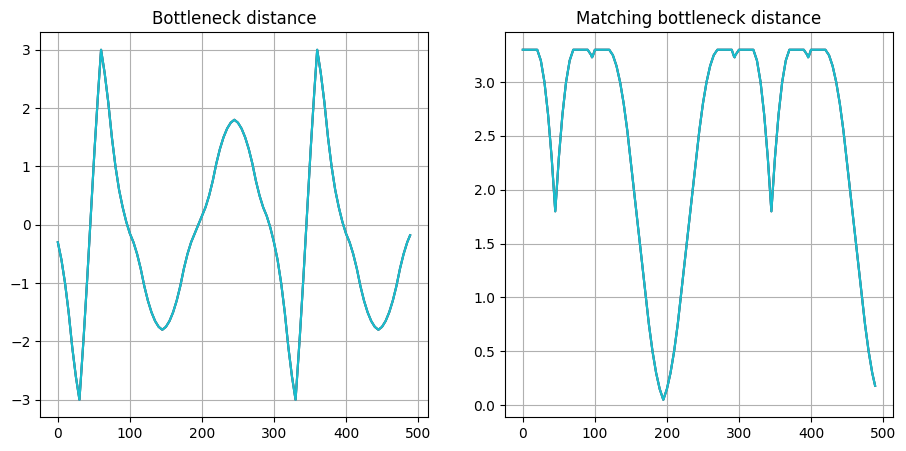

In [20]:
fig, ax = plt.subplots(ncols=2, figsize=(11,5))
cmap = plt.cm.get_cmap('tab10', 3)
for j, quartile_list in enumerate([quartile_bottle_HL, quartile_matching_HL]):
    indices = np.arange(quartile_list.shape[1])
    for i in range(3):
        ax[j].plot(indices, quartile_list[i], color=cmap(i))
    ax[j].grid(True)  
ax[0].set_title("Bottleneck distance")
ax[1].set_title("Matching bottleneck distance")
plt.savefig("plots/xyalpha.png")

In [21]:
def draw(i):
    if i < 0 or i >=600:
        i = 0
    circle_radius = 0.2
    fig, ax = plt.subplots(figsize=(8, 6))
    for robot in poses[i]:
        x, y, orientation = robot
    
        # Draw the robot as a circle
        circle = plt.Circle((x, y), circle_radius, color='blue', alpha=0.5)
        ax.add_artist(circle)
    
        # Draw the orientation as an arrow
        arrow_dx = circle_radius * np.cos(orientation)
        arrow_dy = circle_radius * np.sin(orientation)
        ax.arrow(x, y, arrow_dx, arrow_dy, head_width=0.1, head_length=0.1, fc='red', ec='red')
    
    # Set axis limits and aspect ratio
    ax.set_xlim(-0.5, 20.5)
    ax.set_ylim(-0.5, 3.5)
    ax.set_aspect('equal')
    ax.set_title(f'Robots with Orientations (step {i})')
    plt.xlabel('X Position')
    plt.ylabel('Y Position')
    plt.show()

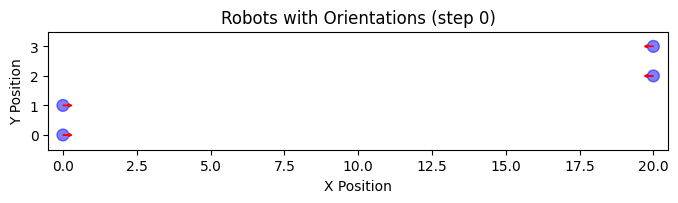

In [22]:
draw(0)